# Packages

In [5]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from eda_utils import plot_reg_and_kde_grid, plot_corr_heatmap

# Importation

In [6]:
project_root = Path.cwd().parent
project_root

data_path = (
    project_root
    / "1_data"
    / "processed"
    / "features"
    / "unemployment_features_stationary.csv"
)

data_path

WindowsPath('d:/Portofolio Data science/Time Series/Explainable_AI_Forecast_and_explain_the_Unemployment_of_USA/1_data/processed/features/unemployment_features_stationary.csv')

In [7]:
df = pd.read_csv(data_path, index_col=0, parse_dates=True)
df.head()

,BUSLOANS,CPIAUCSL,DPCERA3M086SBEA,INDPRO,M2SL,OILPRICEX,RPI,SP500,TB3MS,UNRATE,USREC
date,,,,,,,,,,,
1960-01-01,0.011578,-0.006156,0.001204,0.091976,0.001323,0.0,0.020977,0.017909,0.30,-0.8,0.0
1960-02-01,0.011905,-0.003767,0.006009,0.076960,0.002007,0.0,0.014565,-0.025663,-0.19,-1.1,0.0
1960-03-01,-0.008356,-0.005455,0.021240,0.007959,0.001324,0.0,0.006250,-0.070857,-1.18,-0.2,0.0
1960-04-01,-0.009098,0.005090,0.033752,-0.025916,0.000634,0.0,0.006489,-0.040442,-1.12,0.0,0.0
1960-05-01,-0.000359,0.003383,0.009040,-0.018119,0.003977,0.0,0.007747,-0.010090,-0.67,0.0,1.0


# Split

On ne peut pas utiliser l'ensemble des observations maintenant pour explorer les données, sinon on entraine un dataleakage. 

Il faut donc, séparer les données en TRAIN et TEST :
- TRAIN : avant décembre 1989 ; 
- TEST : après décembre 1990.

Notons bien que celà ne veut pas dire qu'on entrainera plus tard nos modèles de 1960 1989 uniquement. Nos modèles seront entrainés sur la base de Out-Of-Sample(OOS).

Celà veut dire les choses suivantes.

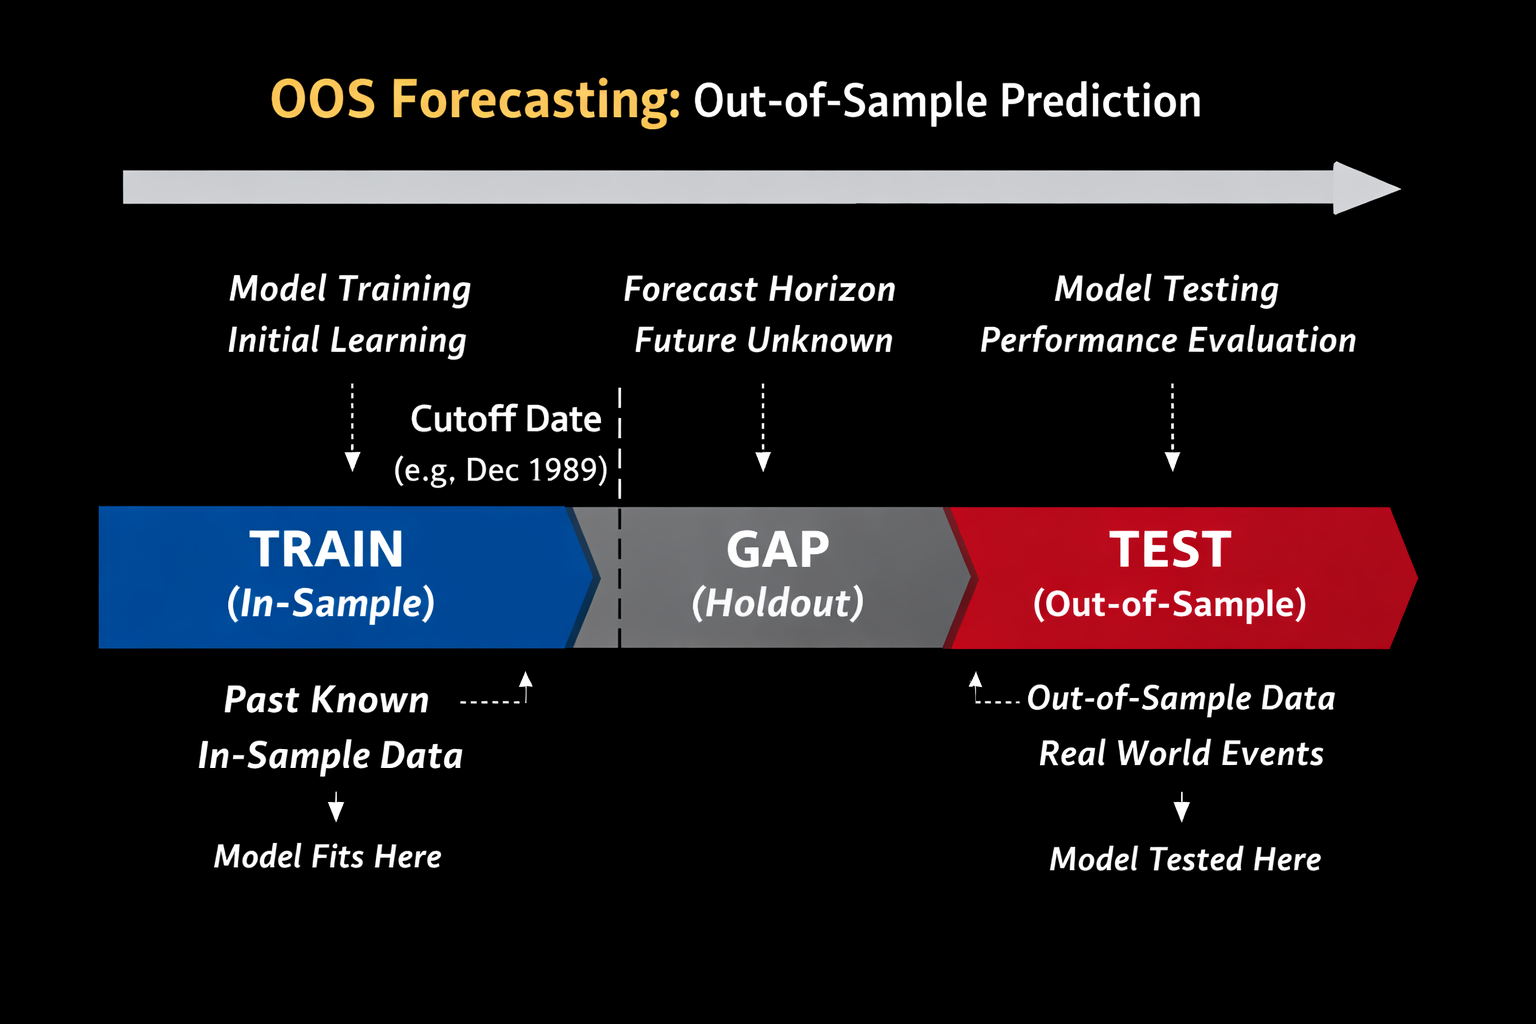

De 1960 à 2025, nos modèles s'entrainent toujours dans un laps de temps et testés dans une autre laps de temps (à préciser ultérieurement l'horizon). A partir de 1990 à 2025, par contre, on évalue en profondeur les modèles s'ils arrivent à bien gérer un environnement macroéconomique distinct, marqué par des crises financières, des politiques monétaires non conventionnelles et des chocs exogènes. 

Notre exploration ne se porte pas sur les périodes post-1990.

In [8]:
end_time_train = "1989-12" # 

df_train = df[df.index <= end_time_train]
df_test = df[df.index > end_time_train]

In [9]:
print(df_train.index[-1])
print(df_test.index[0])

1989-12-01 00:00:00
1990-01-01 00:00:00


# Avoir un dataset décalé de 12 mois

Notre Objectif est de prédire et d'expliquer l'évolution du chômage dans 12 mois. Notre exploration devrait se baser alors sur cette réalité du modèle.

In [15]:
# Colonnes à décaler sauf UNRATE
cols_to_lag = [col for col in df_train.columns if col != "UNRATE"]

# Création des lags 12 pour toutes les variables sauf UNRATE
df_train_lags = df_train[cols_to_lag].shift(12)
df_train_lags.columns = [f"{col}_lags_12" for col in cols_to_lag]

# Ajout du lag 12 de UNRATE
df_train_lags["UNRATE_lags_12"] = df_train["UNRATE"].shift(12)

# Ajout de la colonne UNRATE originale
df_train_lags["UNRATE"] = df_train["UNRATE"]

# Nettoyage
df_train_lags = df_train_lags.dropna()

In [18]:
df_train_lags.head()

,BUSLOANS_lags_12,CPIAUCSL_lags_12,DPCERA3M086SBEA_lags_12,INDPRO_lags_12,M2SL_lags_12,OILPRICEX_lags_12,RPI_lags_12,SP500_lags_12,TB3MS_lags_12,USREC_lags_12,UNRATE_lags_12,UNRATE
date,,,,,,,,,,,,
1961-01-01,0.011578,-0.006156,0.001204,0.091976,0.001323,0.0,0.020977,0.017909,0.30,0.0,-0.8,1.4
1961-02-01,0.011905,-0.003767,0.006009,0.076960,0.002007,0.0,0.014565,-0.025663,-0.19,0.0,-1.1,2.1
1961-03-01,-0.008356,-0.005455,0.021240,0.007959,0.001324,0.0,0.006250,-0.070857,-1.18,0.0,-0.2,1.5
1961-04-01,-0.009098,0.005090,0.033752,-0.025916,0.000634,0.0,0.006489,-0.040442,-1.12,0.0,0.0,1.8
1961-05-01,-0.000359,0.003383,0.009040,-0.018119,0.003977,0.0,0.007747,-0.010090,-0.67,1.0,0.0,2.0


# Analyse bivariée

- Avant de développer un modèle d'IA, il faut comprendre la nature de relation entre la variable cible et à expliquer UNRATE avec les prédicateurs. Celà nous permet de penser aux modèles possiblement adaptables dans nos données. 
- L'hypothèse centrale à vérifier est que : leur relation est-t-elle linéaire?
- Quelles variables sont succeptibles d'influencer le UNRATE dans un modèle linéaire ?

## Scatter plot

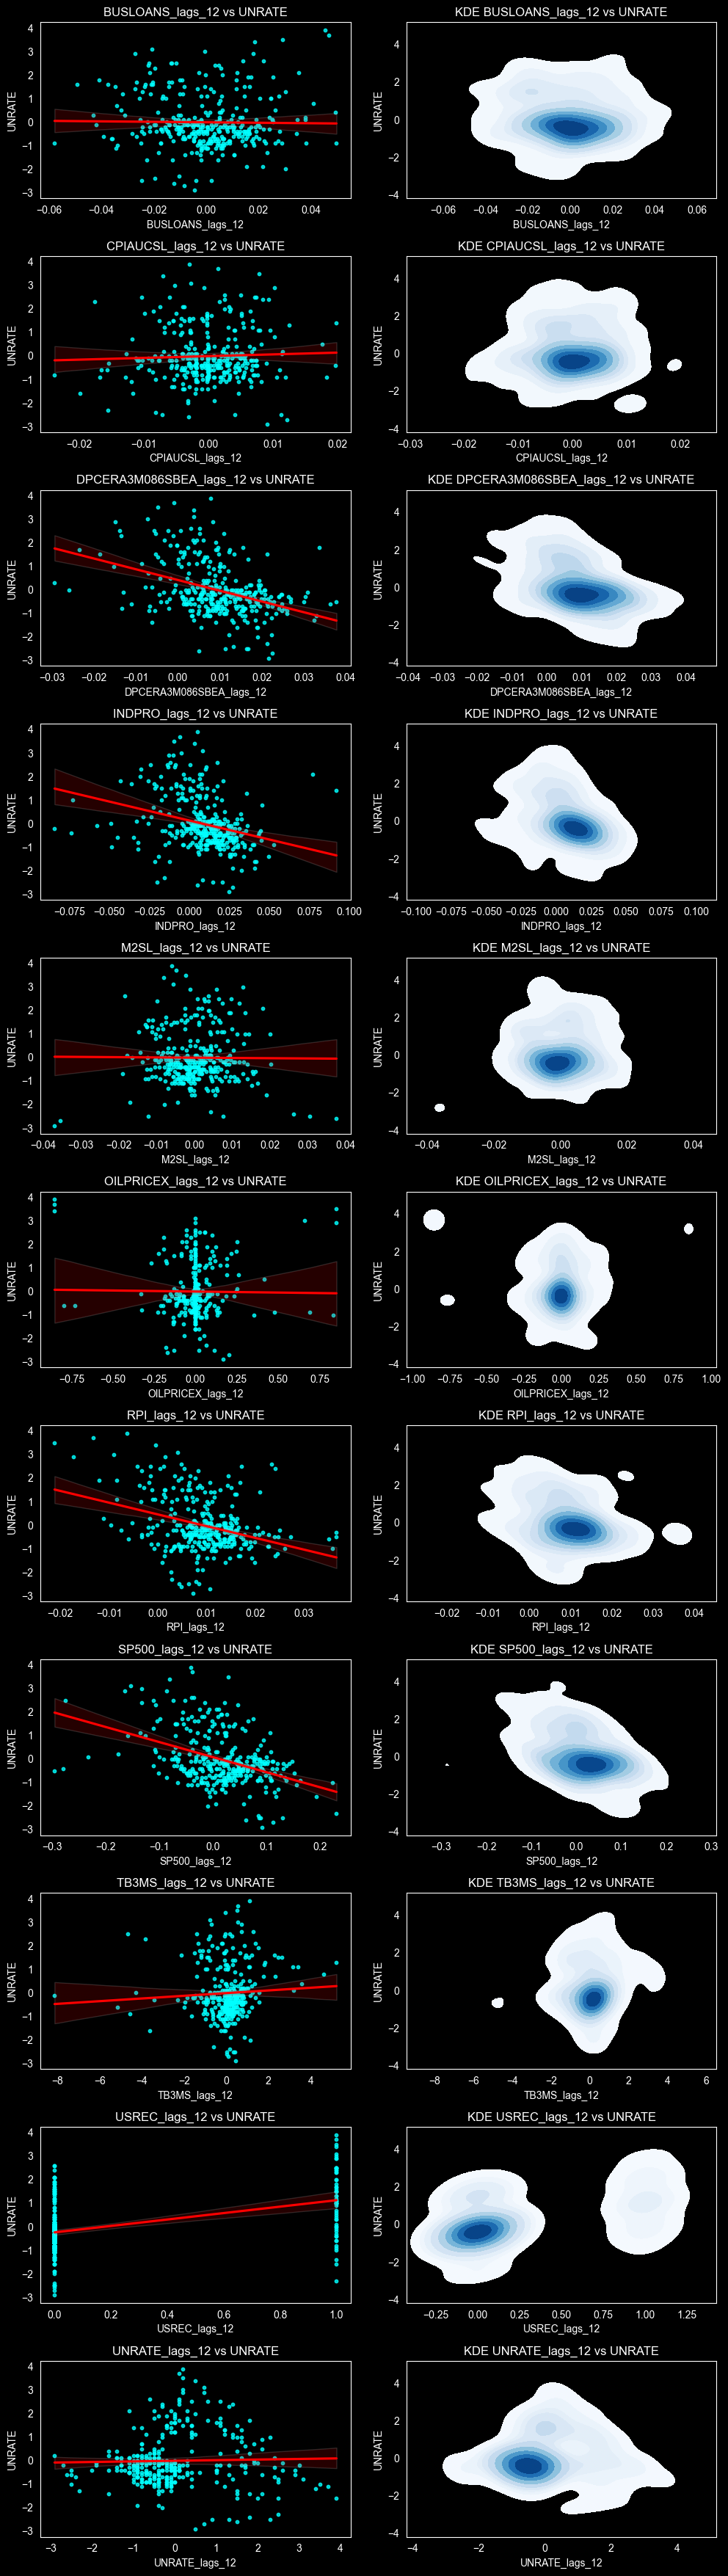

In [19]:
plot_reg_and_kde_grid(df_train_lags, y="UNRATE")

**Règles de lecture dans le cadre de l'hypothèse de linéarité**
- A gauche, on le scatter plot de chaque variable avec le taux de chômage. Ce qui est intéressant ici c'est 
    - Pente rouge : droite de régression linéaire entre les deux variables
    - La pente est équipée d'intervalle de confiance
    - Pente forte + nuage serré → relation claire
    - Pente faible + nuage dispersé → relation faible
    - Beaucoup de dispersion → incertitude élevée
- A droite, il y a l'estimation de la densité des points des deux variables pour mesurer le zone de concentration des observations :
  - Zones foncées -> beaucoup d'observations
  - Forme circulaire
  - allongé en diagonale → lien réel
  - rond → lien faible / nul
  - plusieurs “blobs” → régimes différents

## Interprétation

- On s'aperçoit que les variables pro-cycliques de l'économie sont corrélées au taux de chômage : 
    - INDPRO : Une augmentation du taux de croissance de la production industrielle signifierait une baisse du taux de croissance du chômage et vice-versa ;   
    - RPI : La direction du changement de revenu anticipe celle du chômage ; 
    - La consommation des ménages (DPCE) va aussi dans ce sens du revenu.
- La performance du système financier aussi, à travers l'indice boursier SP500, nous permet d'anticiper le chômage à venir. 
- Pour les autres variables, on constate une densité circulaire. Ce qui signifie qu'il existe une faible dépendance linéaire.
- Nous allons quantifier la corrélation pour confirmer notre analyse.

## Quantifier la corrélation

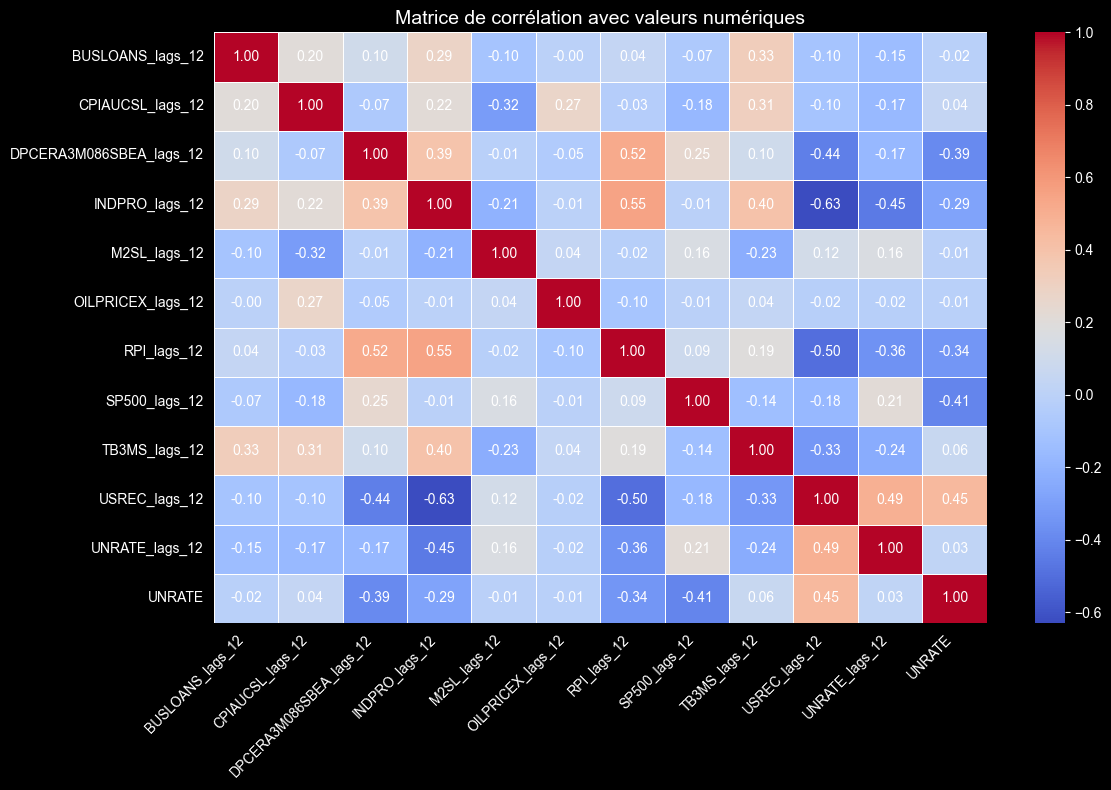

In [20]:
plot_corr_heatmap(df_train_lags)

La quantification de la corrélation nous sert à confirmer notre étude ci-dessus. Voici donc les variables qui permettent d'anticiper la croissance de chômage dans 12 mois :
- SP500 (0.41) ; 
- DP (-0.39) ;
- RPI (-0.34) ; 
- INDPRO (0.29) ; 

Une autre relation s'émerge ici, celle du taux de chômage et de la récession (USREC). D'ailleurs, c'est la relation la plus forte. Essayons de traduire la relation à partir d'un graphique.

## Relation entre taux de chômage et la récession

In [21]:
df_train_lags.columns

Index(['BUSLOANS_lags_12', 'CPIAUCSL_lags_12', 'DPCERA3M086SBEA_lags_12',
       'INDPRO_lags_12', 'M2SL_lags_12', 'OILPRICEX_lags_12', 'RPI_lags_12',
       'SP500_lags_12', 'TB3MS_lags_12', 'USREC_lags_12', 'UNRATE_lags_12',
       'UNRATE'],
      dtype='object')

<Axes: title={'center': 'UNRATE'}, xlabel='USREC_lags_12'>

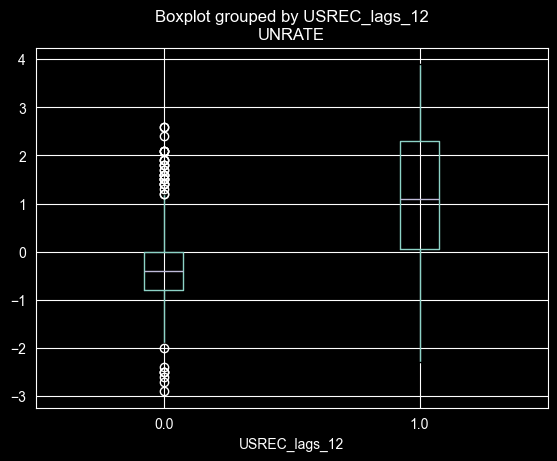

In [22]:
df_train_lags.boxplot("UNRATE", by="USREC_lags_12")

On constate que les taux de croissance chômage durant la période de récession sont nettement différentes que durant le temps normal. Dans la période de mauvaise performance économique, le chômage s'accroit de 1% en général. En temps normal, la tendance est à la baisse. Des valeurs extrêmes peuvent avoir lieu quand même.  